<class 'numpy.ndarray'>
(60000, 1, 28, 28)
<class 'numpy.ndarray'>
(10000, 1, 28, 28)


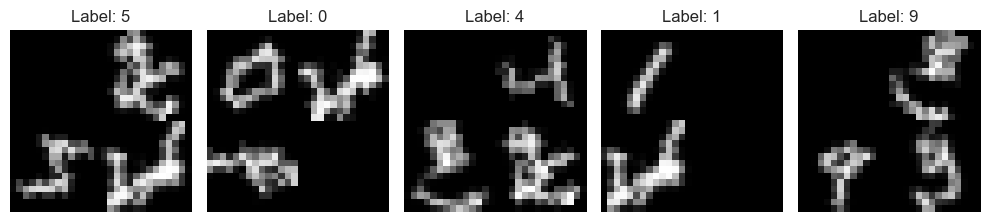

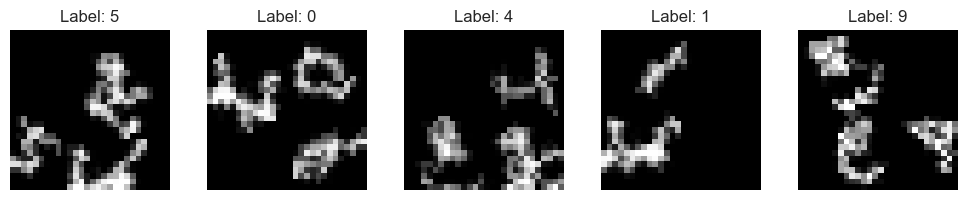

In [1]:

from torch.utils.data import DataLoader, Dataset, Subset
import pickle
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Load Data
with open('Train.pkl', 'rb') as f:
    train_data = pickle.load(f)
print(type(train_data))  # Expected: numpy.ndarray
print(train_data.shape)  # Expected: (num_samples, 1, 28, 28)

with open('Test.pkl', 'rb') as f:
    test_data = pickle.load(f)
print(type(test_data))  # Expected: numpy.ndarray
print(test_data.shape)  # Expected: (num_samples, 1, 28, 28)

labels_df = pd.read_csv('Train_labels.csv')
train_labels = labels_df['class'].values  # Assuming 'class' is the column name for labels
# Visualize the first 5 images
def visualize_images(data, labels, count=5):

    plt.figure(figsize=(10, 5))
    for i in range(count):
        image = data[i, 0, :, :]  # Assuming data shape is (num_samples, 1, height, width)
        label = labels[i]
        
        plt.subplot(1, count, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Label: {label}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize the first 5 images
visualize_images(train_data, train_labels, count=5)

# Data Augmentation Transforms
# Define transformations for training and testing data
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transforms = transforms.Compose([
    transforms.ToPILImage(),               # Convert NumPy arrays to PIL images
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# Define PyTorch Dataset with Augmentation
class EMNISTDataset(Dataset):
    def __init__(self, images, labels=None, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].squeeze(0)  # Remove channel dimension for transforms
        if self.transform:
            image = self.transform(image)
        if self.labels is not None:
            label = self.labels[idx]
            return image, label
        else:
            return image

# Create datasets
train_dataset = EMNISTDataset(train_data, train_labels, transform=train_transforms)
test_dataset = EMNISTDataset(test_data, transform=test_transforms)

# Check augmented data
import matplotlib.pyplot as plt

# Visualize a few augmented training images
def visualize_data(dataset, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert to HWC format for visualization
        img = (img * 0.5 + 0.5)  # De-normalize to [0, 1]
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_data(train_dataset)


In [2]:

if torch.cuda.is_available():
    print("CUDA is available! Training will run on the GPU.")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Device Count: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Training will run on the CPU.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA is available! Training will run on the GPU.
GPU Name: NVIDIA GeForce RTX 4050 Laptop GPU
CUDA Device Count: 1


In [3]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.residual = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self, x):
        residual = x
        x = self.features(x)
        x = self.residual(x) + x  # Add residual connection
        x = self.classifier(x)
        return x

# Update Training Function with Label Smoothing
def train_model(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def confusion_data(model, loader, device):
    model.eval()
    correct, total = 0, 0
    all_preds = []  
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)


# Loss with Label Smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.confidence = 1.0 - smoothing
        self.num_classes = num_classes

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        true_dist = torch.zeros_like(pred)
        true_dist.fill_(self.smoothing / (self.num_classes - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=-1))

In [4]:

# Update Training Process
# kf = KFold(n_splits=2, shuffle=True, random_state=42)
# fold_results = []
# 
# for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
#     print(f"Fold {fold + 1}")
#     train_subset = Subset(train_dataset, train_idx)
#     val_subset = Subset(train_dataset, val_idx)
# 
#     train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
#     val_loader = DataLoader(val_subset, batch_size=64)
# 
#     model = ImprovedCNN(num_classes).to(device)
#     criterion = LabelSmoothingLoss(num_classes=num_classes, smoothing=0.1)
#     optimizer = optim.AdamW(model.parameters(), lr=0.001)
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)
# 
#     for epoch in range(20):  # Increase epochs to ensure better convergence
#         train_loss = train_model(model, train_loader, criterion, optimizer, device)
#         val_accuracy = evaluate_model(model, val_loader, device)
#         scheduler.step(val_accuracy)
#         print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
# 
#     fold_results.append(val_accuracy)

In [ ]:

# Fixed 80-20 Train-Validation Split
from sklearn.model_selection import train_test_split

# Split the dataset
train_idx, val_idx = train_test_split(
    np.arange(len(train_dataset)), test_size=0.2, random_state=42, shuffle=True
)

train_subset = Subset(train_dataset, train_idx)
val_subset = Subset(train_dataset, val_idx)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(train_labels))
model = ImprovedCNN(num_classes).to(device)

criterion = LabelSmoothingLoss(num_classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training and evaluation
results = []
for epoch in range(20):  # Increased epochs for better convergence
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    val_accuracy = evaluate_model(model, val_loader, device)
    scheduler.step(val_accuracy)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    results.append(val_accuracy)

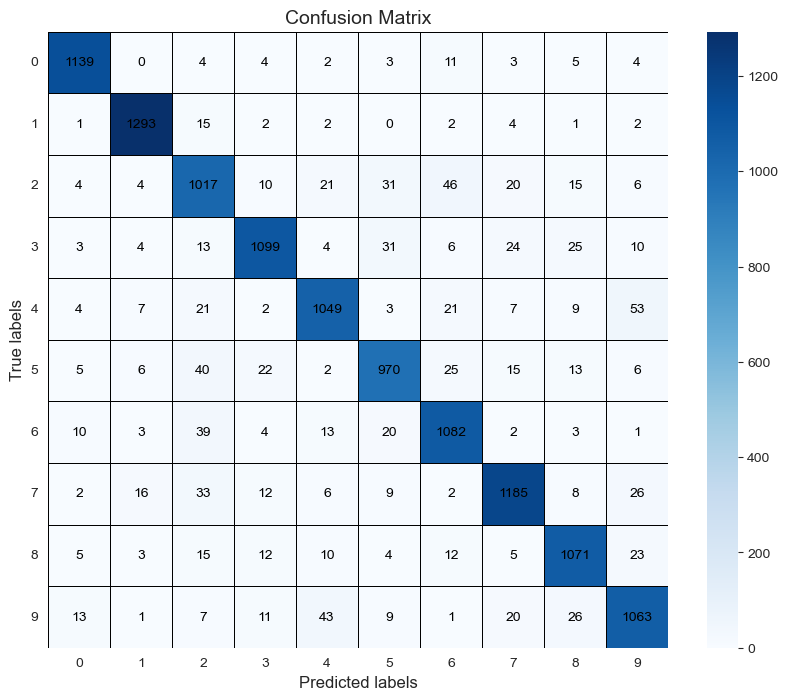


Validation results:
Validation Accuracy: [0.40908333333333335, 0.6774166666666667, 0.74275, 0.8195, 0.8399166666666666, 0.8688333333333333, 0.8665833333333334, 0.863, 0.8829166666666667, 0.8875, 0.8924166666666666, 0.8911666666666667, 0.8969166666666667, 0.8975, 0.9, 0.9045, 0.901, 0.9024166666666666, 0.9045, 0.91]
Mean accuracy: 0.8429
Standard deviation: 0.1150


In [11]:
preds, labels = confusion_data(model, val_loader, device)

# Create confusion matrix
conf_matrix = confusion_matrix(labels, preds)

# Plotting confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    conf_matrix,
    annot=False,            # Disable built-in annotations
    cmap="Blues",
    cbar=True,
    fmt="d",
    linewidths=0.5,         # Add grid lines for better visibility
    linecolor="black"       # Use black lines to separate blocks
)

# Add custom annotations for all cells, including zeros
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        value = conf_matrix[i, j]
        ax.text(
            j + 0.5,         # Horizontal position
            i + 0.5,         # Vertical position
            str(value),      # Convert value to string
            ha="center",     # Center align horizontally
            va="center",     # Center align vertically
            color="black",   # Annotation color
            fontsize=10      # Annotation font size
        )

# Set axis labels and title
plt.xlabel("Predicted labels", fontsize=12)
plt.ylabel("True labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(np.arange(conf_matrix.shape[1]) + 0.5, labels=np.arange(conf_matrix.shape[1]), fontsize=10)
plt.yticks(np.arange(conf_matrix.shape[0]) + 0.5, labels=np.arange(conf_matrix.shape[0]), fontsize=10, rotation=0)
plt.show()

# Results Summary
print("\nValidation results:")
print(f"Validation Accuracy: {results}")
print(f"Mean accuracy: {np.mean(results):.4f}")
print(f"Standard deviation: {np.std(results):.4f}")


In [6]:
# Train the model on the entire training dataset
full_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define model, criterion, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(np.unique(train_labels))

model = ImprovedCNN(num_classes).to(device)
criterion = LabelSmoothingLoss(num_classes=num_classes, smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# Training function for the entire dataset
def train_full_model(model, loader, criterion, optimizer, scheduler, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        scheduler.step(running_loss / len(loader))
        print(f"Epoch {epoch + 1}, Loss: {running_loss / len(loader):.4f}")

# Train the model
print("Training the model on the full dataset...")
train_full_model(model, full_train_loader, criterion, optimizer, scheduler)

# Predict on the test dataset
def predict(model, loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return np.array(predictions)

print("Making predictions on the test dataset...")
test_predictions = predict(model, test_loader)

# Save predictions to a CSV file
output_df = pd.DataFrame({
    'Id': range(1, len(test_predictions) + 1),
    'Class': test_predictions
})
output_df.to_csv('output_3.csv', index=False)



Training the model on the full dataset...
Epoch 1, Loss: 2.1309
Epoch 2, Loss: 1.5824
Epoch 3, Loss: 1.2012
Epoch 4, Loss: 1.0423
Epoch 5, Loss: 0.9701
Epoch 6, Loss: 0.9027
Epoch 7, Loss: 0.8803
Epoch 8, Loss: 0.8686
Epoch 9, Loss: 0.8565
Epoch 10, Loss: 0.8340
Epoch 11, Loss: 0.8254
Epoch 12, Loss: 0.8198
Epoch 13, Loss: 0.8188
Epoch 14, Loss: 0.8064
Epoch 15, Loss: 0.7981
Epoch 16, Loss: 0.7970
Epoch 17, Loss: 0.7950
Epoch 18, Loss: 0.7910
Epoch 19, Loss: 0.7892
Epoch 20, Loss: 0.7875
Making predictions on the test dataset...
